### Anomaly Detection
Author: Garret O'Connell

### The Data Set
Account information of users who could be verified as fake or not fake. The publisher has an incentive to provide a fraud traffic since it gets compensated by the registrations.

### Task 1.
Build a model to classify users coming through the affiliate network in order to detect publishers’ fraud after registration.

#### Algorithm choice:
* One-class SVM is an unsupervised algorithm that learns a decision function for fraud/novelty detection by classifying new data as similar or different to the training set.

#### Data cleaning and model fitting
* I randomly sampled 10% of the data to use for training the prototype model.
* I used a train-test split of 4:1.
* I used grid search with 5 fold cross validation for parameter tuning. 
* I estimated a new feature of time-of-day and from the date-time data to test if fake cases peak at certain times.

#### Inputs required
* Place test_dataset.csv in same folder as notebook to run.

#### Results
* The SVM classified with an accuracy of 92.8% (base rate = 7.5%) with a precision-recall AuC of 93% (see figure below).
* The most important features were identified as: 1) publisher 2) password 3) username (see figure below).

In [4]:
 # set paths
import os
import pandas as pd
import numpy as np

# import data
path = os.getcwd()
df = pd.read_csv(os.path.join(path,'test_dataset.csv'), index_col = False) 

#### Do some passwords have a higher frequency of fraud?
To examine if there are patterns of fraud in passwords, I plotted the frequency of the most common fake passwords. The plots indicate that for most of the passwords there was a negligible rate of fraud, with the exception of the most frequent '123456' which had a noteably higher rate of fraud, making up 0.6% of fraud cases. However this effect appeared to be uninformative as it was due to this password being used more often than others, as was also found to be the leading password among non-fake users.

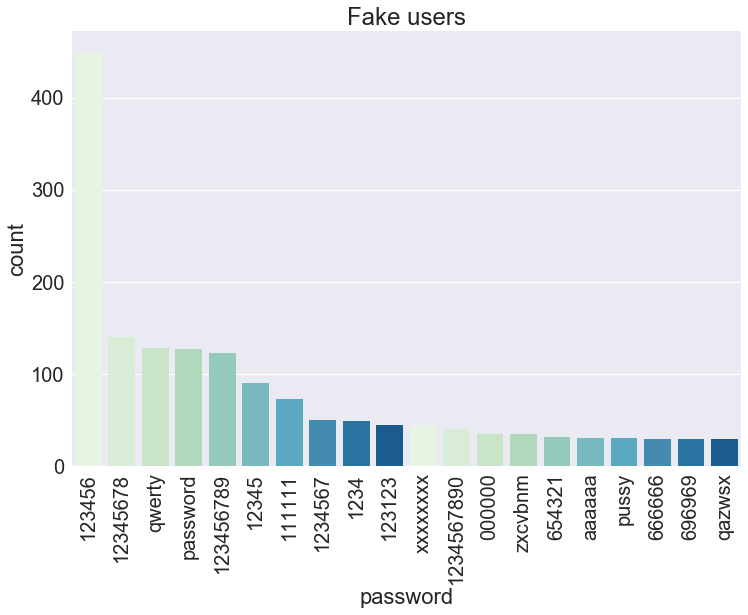

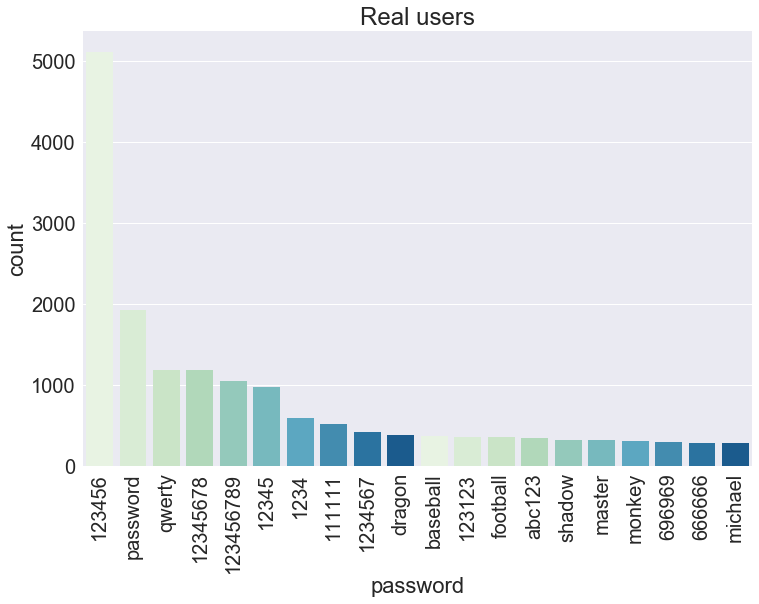

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt 

# get frequency of fake passwords
df_fakepass = df.groupby(['password','is_fake']).size().reset_index().rename(columns={0:'count'}).sort_values(['is_fake','count'], ascending=False)
df_realpass = df.groupby(['password','is_fake']).size().reset_index().rename(columns={0:'count'}).sort_values(['is_fake','count'], ascending=[True,False])

# plot most frequent 20
sns.set_style("whitegrid")
sns.set(font_scale=2)

plt.figure(figsize=(12,8))
ax = sns.barplot(x="password", y="count", data=df_fakepass.head(20), palette=sns.color_palette("GnBu", 10)).set_title('Fake users')
plt.xticks(rotation='vertical')
plt.show()

# plot most frequent 20
plt.figure(figsize=(12,8))
ax = sns.barplot(x="password", y="count", data=df_realpass.head(20), palette=sns.color_palette("GnBu", 10)).set_title('Real users')
plt.xticks(rotation='vertical')
plt.show()

#### Do some publishers have a higher frequency of fraud?
To examine if certain publishers were more often involved in cases of fraud, I plotted the frequency of publishers among fake and real users. The plots indicate that certain publishers were more selectively associated with fraud, as there was no overlap between the most frequent publishers associated with fake and real users. Implementing additional security checks on users associated with these publishers could be effective in reducing the rates of fake users.

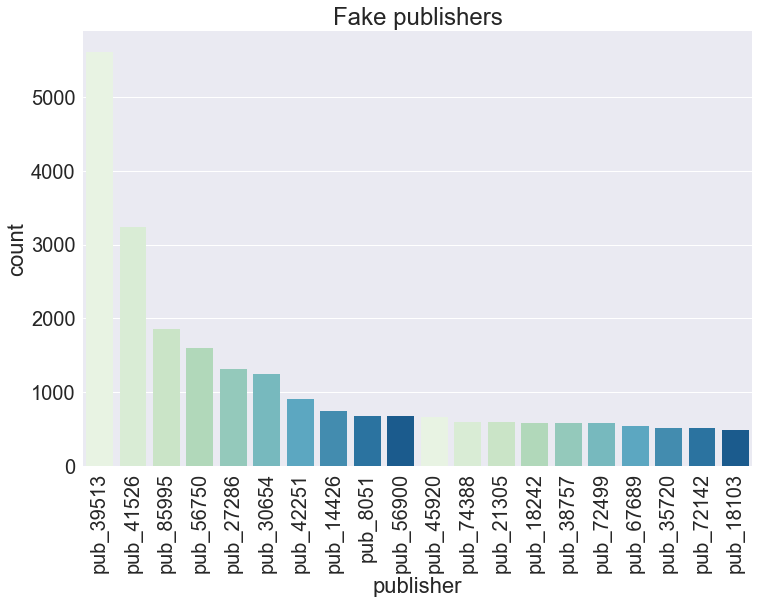

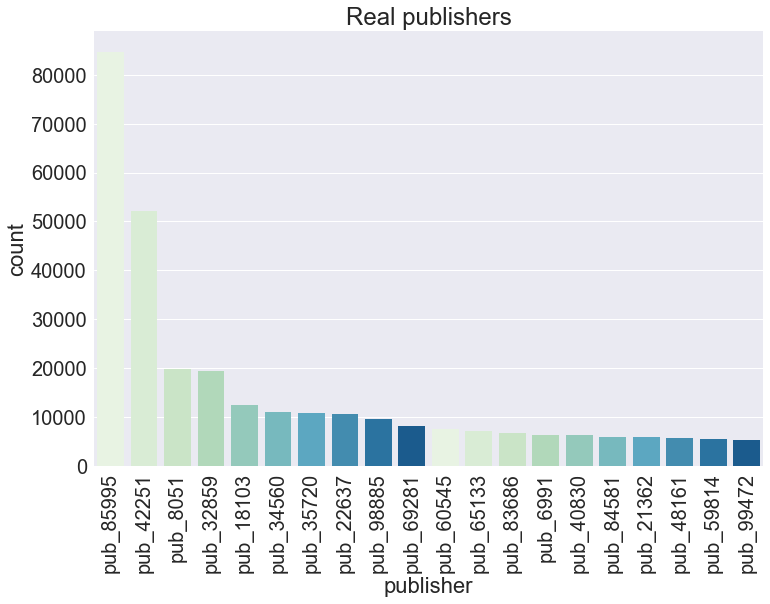

In [10]:
import seaborn as sns

# get frequency of fake passwords
df_fakeuser = df.groupby(['publisher','is_fake']).size().reset_index().rename(columns={0:'count'}).sort_values(['is_fake','count'], ascending=False)
df_realuser = df.groupby(['publisher','is_fake']).size().reset_index().rename(columns={0:'count'}).sort_values(['is_fake','count'], ascending=[True,False])

# plot most frequent 20
sns.set_style("whitegrid")
sns.set(font_scale=2)

plt.figure(figsize=(12,8))
ax = sns.barplot(x="publisher", y="count", data=df_fakeuser.head(20), palette=sns.color_palette("GnBu", 10)).set_title('Fake publishers')
plt.xticks(rotation='vertical')
plt.show()

# plot most frequent 20
plt.figure(figsize=(12,8))
ax = sns.barplot(x="publisher", y="count", data=df_realuser.head(20), palette=sns.color_palette("GnBu", 10)).set_title('Real publishers')
plt.xticks(rotation='vertical')
plt.show()

In [11]:
import time
import datetime 

df['register_datetime'] =  pd.to_datetime(df['register_datetime'], format="%Y-%m-%d %H:%M:%S")
df['timeofday'] = df['register_datetime'].dt.hour + df['register_datetime'].dt.minute/60
df['register_datetime'] = (df['register_datetime'] - df['register_datetime'].min())  / np.timedelta64(1,'D')

In [12]:
# record labels for decode after classification
cat_columns = ["username","password","publisher",'domain','partner','is_fake']
label_list = []
for column in cat_columns:
    df[column] = df[column].astype('category')
    label_list.append(dict( enumerate(df[column].cat.categories) ))
    df[column] = df[column].astype('category').cat.codes

In [13]:
# randomly sample to reduce data
sample_ratio = .1
df = df.sample(frac=sample_ratio)

#### Rate of Fraud
Here I assessed the frequency of fraud cases. A fraud rate of 7.61% was observed. 

In [41]:
# code outliers
df.loc[df['is_fake'] == 0, 'fraud'] = 1  
df.loc[df['is_fake'] != 0, 'fraud'] = -1

print("Fraud rate:")
print("%.2f"%(100*(outliers.shape[0]/df.shape[0])),'%')

Fraud rate:
7.61 %


In [42]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.75)

/Users/goconnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [44]:
# extract labels
y_train = train['fraud']
X_train = train.drop(['is_fake','fraud'],axis=1)
y_test = test['fraud']
X_test = test.drop(['is_fake','fraud'],axis=1)

#### Grid search for parameter tuning

Grid search was used to find optimal scalar parameter values and kernel type (linear vs. non-linear) by identifying the combinations that resulted in highest accuracy.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
from sklearn import grid_search

def svc_param_selection(X, y, nfolds):
    gammas = [50,5]
    nus = [.0001,.000001]
    param_grid = {'gamma' : gammas, 'kernel':['linear'], 'nu' : nus}
    clf_svm = svm.OneClassSVM()
    grid_search_out = grid_search.GridSearchCV(clf_svm, param_grid, cv=nfolds, scoring="accuracy")
    grid_search_out.fit(X_train,y_train)
    
    grid_search_out.best_params_
    return grid_search_out.best_params_

grid_params = svc_param_selection(regular_train, y_train, 5)

In [49]:
grid_params

{'gamma': 50, 'kernel': 'linear', 'nu': 1e-06}

In [50]:
# fit the model
clf_svm = svm.OneClassSVM(nu=.000001, kernel="linear", gamma=50)
clf_svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=50, kernel='linear',
      max_iter=-1, nu=1e-06, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [51]:
from sklearn import metrics  
preds = clf_svm.predict(X_test)  

print("accuracy: ", metrics.accuracy_score(y_test, preds))  
print("precision: ", metrics.precision_score(y_test, preds))  
print("recall: ", metrics.recall_score(y_test, preds))  
print("f1: ", metrics.f1_score(y_test, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(y_test, preds))  

accuracy:  0.92824
precision:  0.928277131085
recall:  0.999956909553
f1:  0.962784715596
area under curve (auc):  0.499978454777


#### Precision-recall curve

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. 

AuC:  0.929563800924


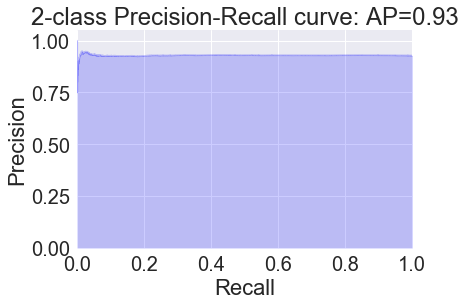

In [52]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = clf_svm.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
precisionrecall_auc = average_precision_score(y_test, y_score)  
print('AuC: ',precisionrecall_auc)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

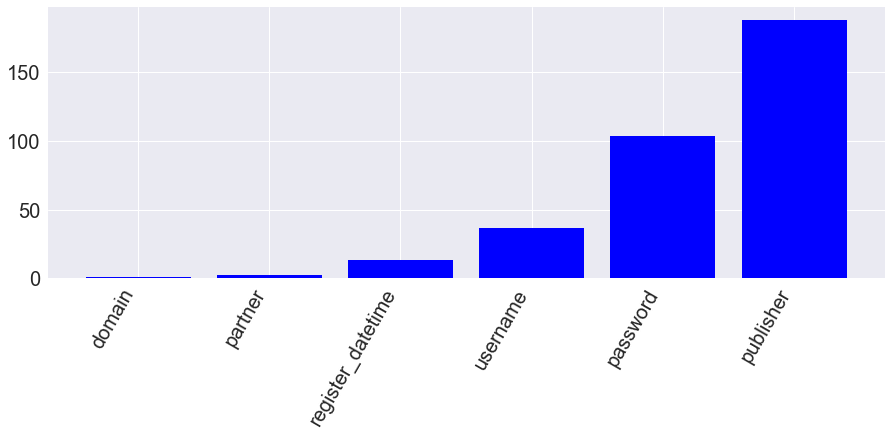

In [53]:
# feature importance 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

top_features = 5
coef = clf_svm.coef_.ravel()
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

def plot_coefficients(clf_svm, feature_names, top_features=6):
    coef = clf_svm.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_coefficients = np.hstack([top_positive_coefficients])
 
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.grid(True)
    plt.show()
    
# plot feature importance
plot_coefficients(clf_svm, list(df.columns.values))